In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.font_manager as mfm
import matplotlib as mpl
from scipy.cluster import hierarchy
import plotly.figure_factory as ff
import mplcursors
import numpy as np
import numpy.linalg as la

import time
import glob,os

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable

from PIL import Image
from imageio import imread

font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
prop = mfm.FontProperties(fname=font_path)


# Loading data

In [2]:
data_dir ='/home/wonton/jiayi/projects/Chinese-charactor-classification/commoncharacter>500'
data_saving_path = data_dir + "_trained_result_image_24/"

In [3]:
os.listdir(data_dir)[0]
names = []
for j in os.listdir(data_dir):
    file = glob.glob(data_dir+"/"+ j+"/*.png")[0]        
    names.append(file)

Print labels in the dataset

In [4]:
labels = np.load(data_saving_path + "/labels.npy") # printing labels
print("Chinese charactors learned by CNN:", )
print(labels)
print(len(names))

Chinese charactors learned by CNN:
['一' '丁' '七' ... '姷' '姹' '姺']
1950


## Get features from trained CNN 

ConvNet has 2 Convolutional layers and 2 Fully Connected layers. The model is trained in the IPython Notebook conv.ipynb and the parameters are saved.

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, depth_1, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(depth_1, depth_2, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(int(size_IMG**2/16) * depth_2, 100)
        self.fc2 = nn.Linear(100, num_classes)
        
    def forward(self, x):
        
        out = self.layer1(x)
        conv_x = self.layer2[0](out)
        
        out = self.layer2(out)
        max_pool_x = out
        
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        
        out = self.fc1(out)
        out = self.fc2(out)
               
        return out, conv_x, max_pool_x

In [6]:
size_IMG = 24
depth_1 = 16
depth_2 = 16
model = torch.load(data_saving_path + "/conv_network_model") # load model
model.eval()


ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=576, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=1950, bias=True)
)

Resizing input images and converting them to a Tensor object

In [8]:

train_transforms = transforms.Compose([transforms.Resize(size_IMG),
                                       transforms.ToTensor(),
                                       ])

## Visualizing feature maps of words '名', '古', '妻'

In [9]:
def plot_feature_map(visu_conv):
    plt.figure(figsize = (10,10))
    f, axarr = plt.subplots(4,4, sharex=True)

    for i in range(4):
        for j in range(4):
            axarr[i,j].imshow(visu_conv[0][i*4+j].cpu().detach().numpy())
            axarr[i,j].axis('off')

#     plt.show()

名 True
妻 True
古 True


<Figure size 720x720 with 0 Axes>

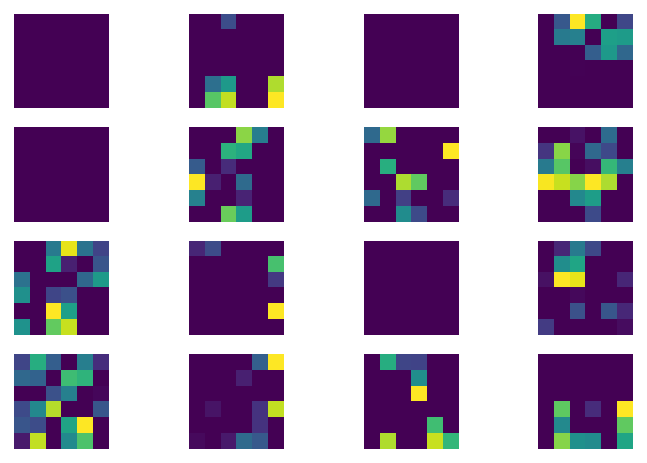

<Figure size 720x720 with 0 Axes>

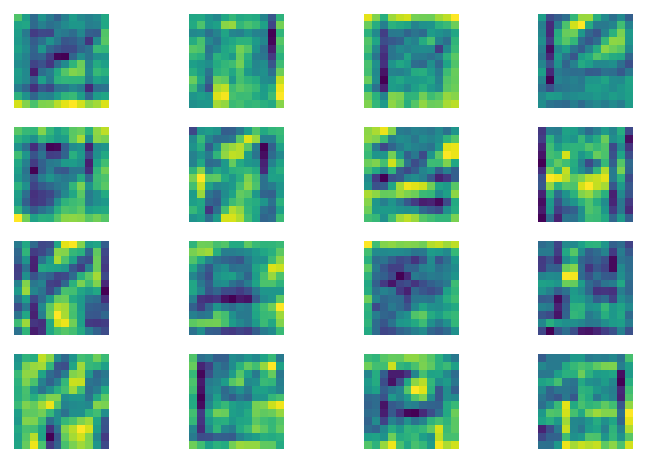

<Figure size 720x720 with 0 Axes>

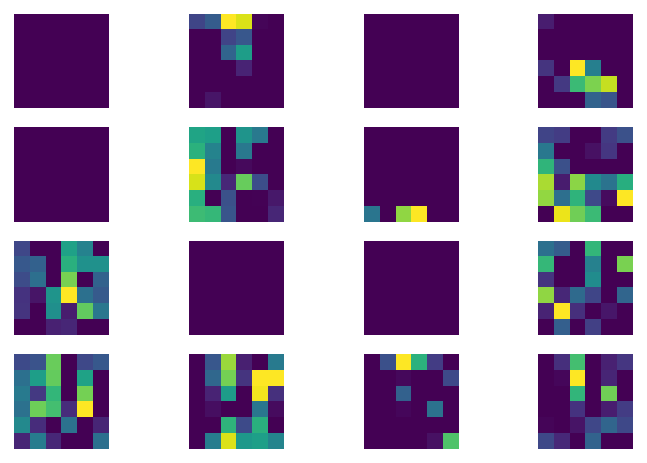

<Figure size 720x720 with 0 Axes>

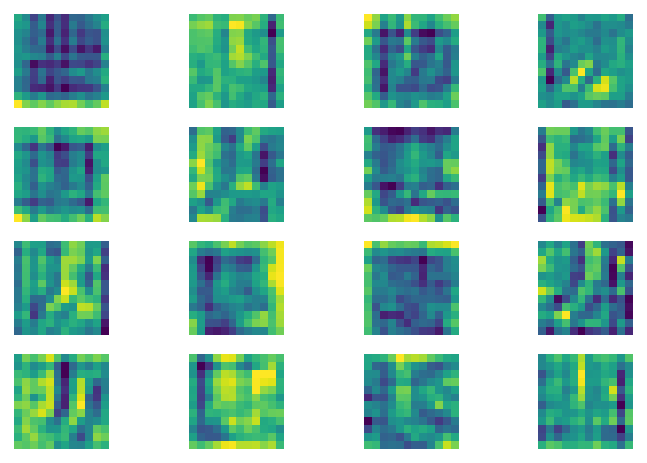

<Figure size 720x720 with 0 Axes>

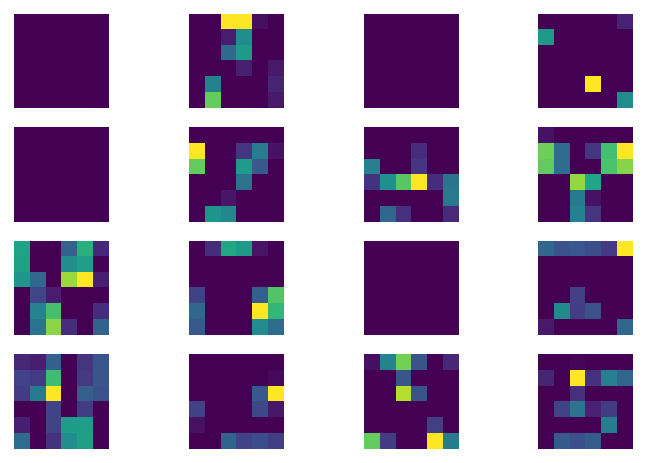

<Figure size 720x720 with 0 Axes>

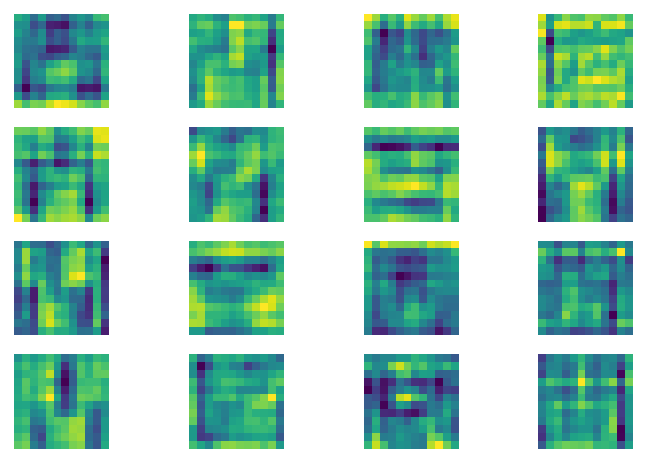

In [11]:
tot_conv = []
tot_vect_conv = []
L = []

for j in os.listdir(data_dir):
    file = glob.glob(data_dir+"/"+ j+"/*.png")[0]
    
    im = Image.open(file)

    tensorimage = train_transforms(im)

    outputs, visu_conv, visu_max_pool = model(tensorimage.view(1,1,size_IMG,size_IMG).cuda())

    vect_conv = visu_max_pool[0].view(-1).cpu().detach().numpy()  
    tot_vect_conv.append(vect_conv) 

    tot_conv.append(visu_max_pool[0].cpu().detach().numpy()) 

    _, predicted = torch.max(outputs.data, 1)
  
    L.append(j)
    
    if j in ['名', '古', '妻']:
        print(j, labels[predicted]==j)
        
        plot_feature_map(visu_max_pool)
        plot_feature_map(visu_conv)
        



In [12]:
tot_vect_conv = np.array(tot_vect_conv)
tor_data = torch.from_numpy(tot_vect_conv)
print(np.shape(tot_vect_conv))

(1950, 576)


## Clustering the feature maps using dendrogram

In [13]:
num = int(len(L))
L = np.array(L)
X = tot_vect_conv[:num] 

Z = hierarchy.linkage(X, 'ward', metric='euclidean')  

thre = 28


In [ ]:


P = 60
dn = hierarchy.dendrogram(Z,  labels=L[:num], truncate_mode= 'lastp', p = P, show_leaf_counts = True,
                          color_threshold= thre, ax = ax)

dn2 = hierarchy.dendrogram(Z, no_labels = True, color_threshold= thre)

In [154]:
def l_re_int(j):
    a = sum([int(dn['ivl'][j][1:-1]) for j in range(0,j+1)])
    b = sum([int(dn['ivl'][j][1:-1]) for j in range(0,j+2)])

    return L[dn2['leaves'][a:b]]
    
print("group_1:", L[dn2['leaves'][:int(dn['ivl'][0][1:-1])]])
groups_names = [str(L[dn2['leaves'][:int(dn['ivl'][0][1:-1])]])]

for i in range(len(dn['ivl'])-1):
    groups_names.append(str(l_re_int(i)))
    
    print("group_%d:"%(i+2), l_re_int(i))
   


group_1: ['唊' '唻' '哧' '咏' '咮' '咪' '咔' '味' '呿' '呔' '吠' '呋' '嘌' '嘿' '啋' '哚' '噤' '嚓'
 '喋' '嗓' '噪' '嗑' '嗌' '嗦' '嗉' '唪' '嗪' '噚' '嘒' '囈' '喙' '啄' '嚼' '噙' '嗲']
group_2: ['嗥' '唣' '喤' '嗢' '嘄' '喨' '嘎' '嗄' '侵' '唚' '嘬' '囁' '嗫' '匾' '嗝']
group_3: ['喂' '哏' '喟' '唱' '嚜' '嘴' '嗤' '喘' '囓' '嚾' '嚯' '嘂' '喎' '噣' '塍' '勝' '哕' '啮'
 '嚙' '唢' '哨' '唏' '啼' '嘀' '噱' '噳' '嚧' '噓' '唬' '墟' '嘘' '呧' '啀' '喱' '哐' '囑'
 '嘱' '嚝' '喥']
group_4: ['哫' '呃' '呢' '吸' '叹' '呗' '哌' '呱' '叭' '呎' '听' '叽' '吤' '吩' '吮' '唲' '况' '呪'
 '噬' '哒' '啜' '嘭' '哢' '呒' '咣' '哜' '俳' '啡' '佌' '呲' '吡' '吋' '啪' '哄' '哎' '嘮'
 '呓' '喵' '唠' '啦' '咑' '咐' '哳' '咿' '吼' '哦' '啭' '嚷' '囔' '妙' '吵' '咝' '吪' '唑'
 '吐' '叶' '哇' '吒' '吁' '吧' '叱' '咄' '吲' '叫' '咱' '冲' '呷' '呻' '吓' '卟' '吣' '吨']
group_5: ['丽' '両' '兩' '丞' '亟' '凾' '函' '凼' '亞' '匪' '並' '业' '亚' '叟' '史' '吏' '匝' '叵'
 '匡' '匣']
group_6: ['嘔' '傴' '區' '匯' '匜' '妼' '咇' '佖' '啊' '呵' '坷' '啞' '哑' '嗵' '咂' '哂' '嘓' '呬'
 '咽' '吶' '呐' '啢' '哺' '喃' '匭' '匦' '厖' '伛' '呕']
group_7: ['嗾' '唹' '噉' '啵' '嗷' '嘁' '噘' '厥' '嗽' '啾' '厤' '啉' '咻' '噦' '嘛' '囌' '噺' '嚇'
 '働'

<IPython.core.display.Javascript object>


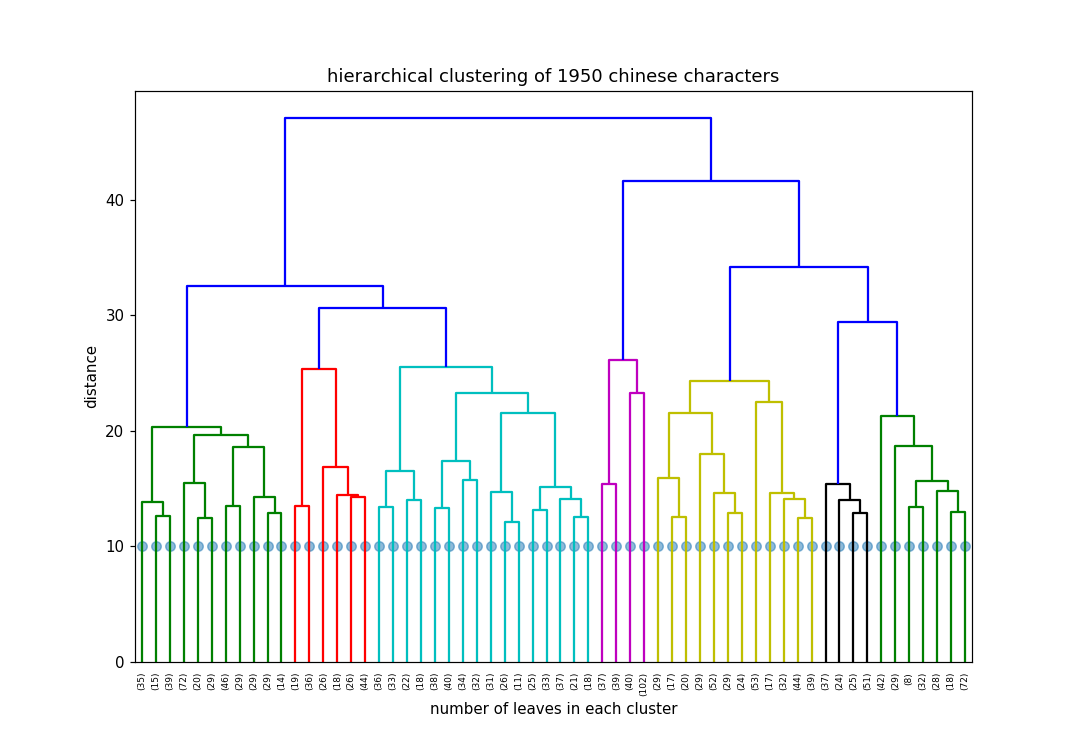

In [29]:
%matplotlib notebook

num_leav = len(dn['ivl'])
x = range(5,num_leav*10,10)
y = np.zeros(num_leav)+10

names = np.array(list(groups_names))


fig = plt.figure(figsize = (10,7))
ax = fig.add_subplot(111)

dn = hierarchy.dendrogram(Z,  labels=L[:num], truncate_mode= 'lastp', p = P, show_leaf_counts = True,
                          color_threshold= thre, ax = ax)
sc = plt.scatter(x,y, s=40, alpha = 0.5)


annot = plt.annotate("", xy=(0,0), xytext=None,
                    bbox=dict(boxstyle="round", fc="orange"),
                    fontproperties=prop, size = 15)
annot.set_visible(False)
plt.title("hierarchical clustering of 1950 chinese characters")
plt.ylabel("distance")
plt.xlabel("number of leaves in each cluster")

def update_annot(ind):

    
    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    
    text = "{}, {}".format(" ".join(list(map(str,ind["ind"]))), 
                           " ".join([names[n] for n in ind["ind"]]))
    annot.set_text(text)
#     annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
    annot.get_bbox_patch().set_alpha(0.8)


def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)

plt.show()

## Compare performace with K-mean using sum of squared errors(SSE)

while k-mean is better at finding bigger clusters, hierarchical clustering is better at finding small clusters

In [136]:
def re_int(j, dn):
    a = sum([int(dn['ivl'][j][1:-1]) for j in range(0,j+1)])
    b = sum([int(dn['ivl'][j][1:-1]) for j in range(0,j+2)])

    return a,b
def mean_matrix(classlabel):
    vec_means = np.mean(tot_vect_conv[classlabel], axis = 0)
    
    vec_means_tile = np.tile(vec_means, (len(classlabel),1))
    
    return vec_means_tile
    
def SSE(P):
    dn = hierarchy.dendrogram(Z,  labels=L[:num], truncate_mode= 'lastp', p = P, show_leaf_counts = True,
                          color_threshold= thre, no_plot = True)
    
    
    classlabel = dn2['leaves'][:int(dn['ivl'][0][1:-1])]
       
    sse = sum(sum((tot_vect_conv[classlabel] - mean_matrix(classlabel))**2))
    
    for i in range(len(dn['ivl'])-1):
        a,b = re_int(i,dn)
        classlabel=dn2['leaves'][a:b]
          
        sse+=sum(sum((tot_vect_conv[classlabel] - mean_matrix(classlabel))**2))
        
    return sse

    

In [160]:
k_mean_sse = np.load("./SSE_k_mean.npy")

In [158]:
sse = []
rlist = range(1,150)
for i in rlist:
    sse.append(SSE(i))
    plt.scatter(i,SSE(i), c = "r")
plt.plot(rlist, sse, c = "r")    

<IPython.core.display.Javascript object>


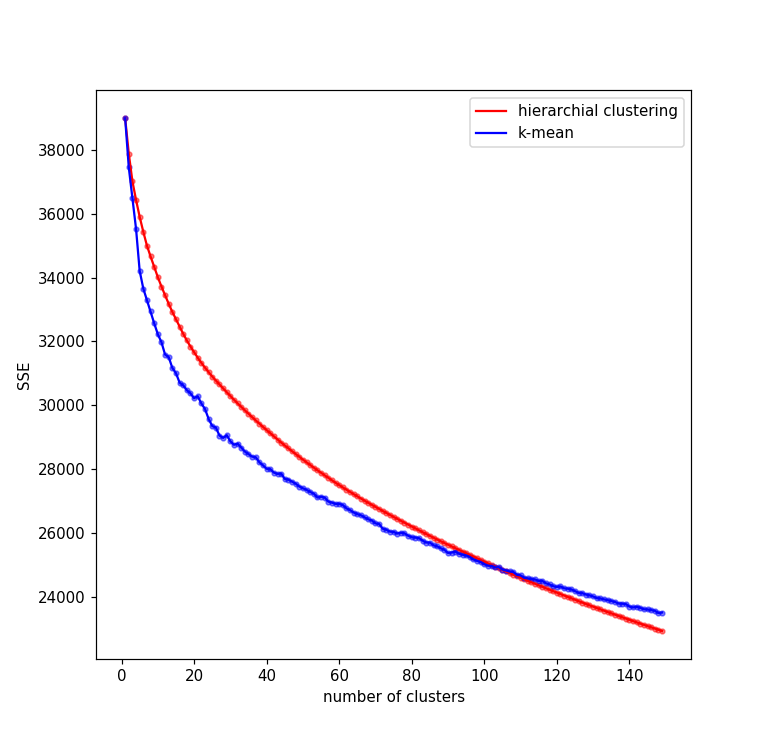

In [181]:
plt.figure(figsize = (8,8))
plt.plot(rlist, sse, c = "r", label= "hierarchial clustering") 
plt.scatter(rlist, sse, c = "r",alpha = 0.5,s = 10) 

plt.plot(rlist, k_mean_sse, c = "b", label = "k-mean") 
plt.scatter(rlist, k_mean_sse, c = "b",alpha = 0.5,s = 10) 
plt.ylabel("SSE")
plt.xlabel("number of clusters")
plt.legend()

In [180]:
print("intersect at", np.where(abs(sse-k_mean_sse)<15)[0][1])

intersect at 104


In [182]:
np.save("./SSE_hierarchical_clustering.npy", sse)